In [2]:
import json
import sys
import warnings
import os

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set the working directory to the opt directory
current_dir = os.getcwd() 
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir + "/opt")

from data_process import DataProcessor

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from ev_opt import EV_Opt
from ev_eval import EVChargerEquityEvaluation

output_dir = "../output/ev_opt_run_2025-08-07_10-22-30/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#set font arial
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

# Read configurations

In [2]:
# read config
with open(os.path.join(output_dir, "kwargs_lst.json"), "r") as f:
    config = json.load(f)

k = config["k"]
equity_indicator_list = config["equity_indicator_list"]
demographic_group_list = config["demographic_group_list"]
disparity_index_list = config["disparity_index_list"]
max_add_capacity_list = config["max_add_capacity_list"]
multi_obj_setting = np.array(config["multi_obj_setting"])

data_processor = DataProcessor()
# set demographic partition based on quantiles
kwargs = {
    "income_bins": k,
    "mud_bins": k,
    "employment_bins": k,
}
# three dfs respectively: demographic data, commute matrix, and VKT flow matrix
df1, df2, df3 = data_processor.process_demo_data(**kwargs)

# set crs to 3857 (from spherical to flat)
df1.crs = "EPSG:4326"
df1 = df1.to_crs("EPSG:3857")

# Read results

In [3]:
# read results
df_result_val = pd.read_csv(output_dir + "df_result_val.csv")
npzfile = np.load(output_dir + "result_val.npz")
charger_capacity_wp = npzfile["arr_0"]
equivalent_char_capacity = npzfile["arr_1"]
equity_indicator_xi = npzfile["arr_2"]
objective_value = npzfile["arr_3"]
obj_sol_within = npzfile["arr_4"]
obj_sol_between = npzfile["arr_5"]


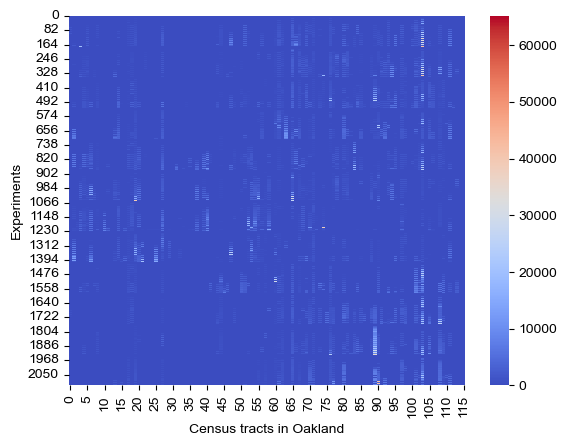

In [4]:
sns.heatmap(charger_capacity_wp, cmap="coolwarm", label="Workplace new charger capacity")
plt.xlabel("Census tracts in Oakland")
plt.ylabel("Experiments")
plt.savefig("%s/heatmap_charger_capacity_wp.pdf" % output_dir, bbox_inches="tight",  dpi = 300)

# Result example plot (Figure 7)

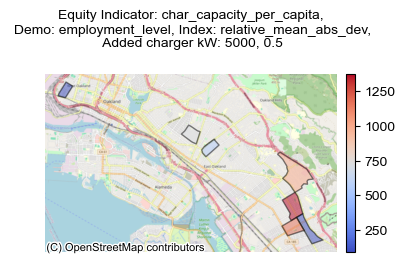

In [5]:
import contextily as ctx
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

equity_indicator = "char_capacity_per_capita"
n0 = len(equity_indicator_list)
demographic_group = "employment_level"
n1 = len(demographic_group_list)
disparity_index = "relative_mean_abs_dev"
n2 = len(disparity_index_list)
max_add_capacity = 5000
n3 = len(max_add_capacity_list)
multi_obj = 0.5
n4 = len(multi_obj_setting)

count_n = (
    equity_indicator_list.index(equity_indicator) * n1 * n2 * n3 * n4 + 
    demographic_group_list.index(demographic_group) * n2 * n3 * n4
    + disparity_index_list.index(disparity_index) * n3 * n4
    + max_add_capacity_list.index(max_add_capacity) * n4
    + np.where(multi_obj_setting == multi_obj)[0][0]
)
# print(demographic_group_list.index(demographic_group) , disparity_index_list.index(disparity_index), max_per_ct_max_total.index([max_per_ct, max_total]), n1, n2, n3, count_n)

charger_capacity_wp_val = charger_capacity_wp[count_n]
equity_indicator_xi_val = equity_indicator_xi[count_n]
obj = objective_value[count_n]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.set_axis_off()

df1["charger_capacity_wp"] = (charger_capacity_wp_val).round(0)
df1["equity_indicator_xi"] = equity_indicator_xi_val
df1_masked = df1.copy()
df1_masked.loc[df1_masked["charger_capacity_wp"] == 0, "charger_capacity_wp"] = np.nan
cmap = matplotlib.colormaps["coolwarm"]
plt.title(f"Equity Indicator: {equity_indicator},\n Demo: {demographic_group}, Index: {disparity_index},\n Added charger kW: {max_add_capacity}, {str(multi_obj)}", fontsize=10, pad=10)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
ux = df1_masked.plot("charger_capacity_wp", ax=ax, edgecolor="k", cmap=cmap, alpha=0.5, legend=True, cax=cax)

ctx.add_basemap(ux, source=ctx.providers.OpenStreetMap.Mapnik)


In [6]:
def add_subplot(equity_indicator, demographic_group, disparity_index, max_add_capacity, multi_obj, ax, norm):
    count_n = (
        equity_indicator_list.index(equity_indicator) * n1 * n2 * n3 * n4
        + demographic_group_list.index(demographic_group) * n2 * n3 * n4
        + disparity_index_list.index(disparity_index) * n3 * n4
        + max_add_capacity_list.index(max_add_capacity) * n4
        + np.where(multi_obj_setting == multi_obj)[0][0]
    )

    charger_capacity_wp_val = charger_capacity_wp[count_n]
    equity_indicator_xi_val = equity_indicator_xi[count_n]
    obj = objective_value[count_n]

    df1["charger_capacity_wp"] = charger_capacity_wp_val.round(0)
    df1["equity_indicator_xi"] = equity_indicator_xi_val
    df1_masked = df1.copy()
    df1_masked.loc[df1_masked["charger_capacity_wp"] == 0, "charger_capacity_wp"] = np.nan
    cmap = matplotlib.colormaps["coolwarm"]

    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="3%", pad=0.1)
    ux = df1_masked.plot("charger_capacity_wp", ax=ax, edgecolor="k", linewidth=1, cmap=cmap, alpha=0.9, legend=True, cax=cax, norm=norm)

    x_lim_min, y_lim_min, x_lim_max, y_lim_max = df1.total_bounds
    y_lim_max = y_lim_max - 0.15 * (y_lim_max - y_lim_min)

    ax.set_xlim(x_lim_min, x_lim_max)
    ax.set_ylim(y_lim_min, y_lim_max)
    aspect_ratio = (x_lim_max - x_lim_min) / (y_lim_max - y_lim_min)
    print(aspect_ratio, x_lim_min, y_lim_min, x_lim_max, y_lim_max)
    ax.set_aspect(aspect_ratio)

    ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager, crs=df1.crs.to_string())

    pass

1.0768755645388977 -13617754.38563326 4537026.188867837 -13593757.02036397 4559310.43976879
1.0768755645388977 -13617754.38563326 4537026.188867837 -13593757.02036397 4559310.43976879
1.0768755645388977 -13617754.38563326 4537026.188867837 -13593757.02036397 4559310.43976879
1.0768755645388977 -13617754.38563326 4537026.188867837 -13593757.02036397 4559310.43976879


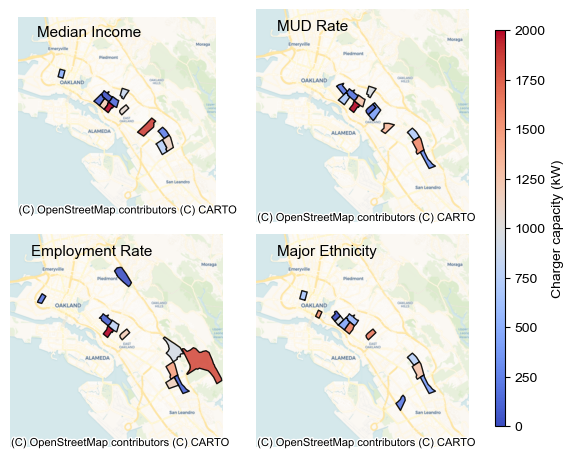

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(5, 6), tight_layout=True)
ax = ax.ravel()
for i in range(4):
    ax[i].set_axis_off()
# Define a shared Normalize object
norm = mcolors.Normalize(vmin=0, vmax=2000)

add_subplot("char_capacity_per_capita", "income_level", "relative_mean_abs_dev", 10000, 0.5, ax[0], norm)
add_subplot("char_capacity_per_capita", "mud_level", "relative_mean_abs_dev", 10000, 0.5, ax[1], norm)
add_subplot("char_capacity_per_capita", "employment_level", "relative_mean_abs_dev", 10000, 0.5, ax[2], norm)
add_subplot("char_capacity_per_capita", "major_ethnicity", "relative_mean_abs_dev", 10000, 0.5, ax[3], norm)

# Add a single color bar for all subplots
# thicken the color bar
fig.subplots_adjust(right=0.85)
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([1, 0.17, 0.02, 0.66])
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label("Charger capacity (kW)", fontsize=10)

ax[0].text(0.1, 0.92, "Median Income", fontsize=11, ha='left', va='center', transform=ax[0].transAxes)
ax[1].text(0.1, 0.92, "MUD Rate", fontsize=11, ha='left', va='center', transform=ax[1].transAxes)
ax[2].text(0.1, 0.92, "Employment Rate", fontsize=11, ha='left', va='center', transform=ax[2].transAxes)
ax[3].text(0.1, 0.92, "Major Ethnicity", fontsize=11, ha='left', va='center', transform=ax[3].transAxes)

plt.savefig("%s/charger_capacity_wp_map_example_10000_22.pdf" % output_dir, bbox_inches="tight",  dpi = 300)

In [8]:
char_kW = 10000
k = 4
w_between = 0.5
slice = df_result_val[df_result_val["equity_indicator"] == "char_capacity_per_capita"][
    df_result_val["demographic_group"] == "income_level"
][df_result_val["disparity_index"] == "relative_mean_abs_dev"][df_result_val["max_add_capacity"] == char_kW][
    df_result_val["weight_between"] == w_between
]

print(
    f"With {k} div, the inter-group and intra-group disparity\n after optimization with {char_kW} were",
    slice.obj_sol_between.values[0],
    slice.obj_sol_within.values[0],
)

With 4 div, the inter-group and intra-group disparity
 after optimization with 10000 were 0.162662980305365 0.4620036339749573


In [9]:
## Originally, inter vs. intra, 2sep: (np.float64(0.15706478107920582), np.float64(0.5348583079860187))
## Originally, inter vs. intra, 4sep: (np.float64(0.21387065320910212), np.float64(0.5062549030512554))
inter_2sep = 0.15706478107920582
intra_2sep = 0.5348583079860187
inter_4sep = 0.21387065320910212
intra_4sep = 0.5062549030512554

inter_decrease = (inter_4sep - slice.obj_sol_between.values[0]) / inter_4sep
intra_decrease = (intra_4sep - slice.obj_sol_within.values[0]) / intra_4sep
inter_decrease, intra_decrease

(np.float64(0.23943291019769408), np.float64(0.08740906766451194))

In [10]:
slice_all = df_result_val[df_result_val["equity_indicator"] == "char_capacity_per_capita"][
    df_result_val["demographic_group"] == "income_level"
][df_result_val["disparity_index"] == "relative_mean_abs_dev"][df_result_val["max_add_capacity"] == char_kW]
slice_all_intra = slice_all.obj_sol_within.values[:-1]
slice_all_inter = slice_all.obj_sol_between.values[1:]

inter_decrease_mean = (inter_4sep - slice_all_inter.mean()) / inter_4sep
intra_decrease_mean = (intra_4sep - slice_all_intra.mean()) / intra_4sep
inter_decrease_max = (inter_4sep - slice_all_inter.min()) / inter_4sep
intra_decrease_max = (intra_4sep - slice_all_intra.min()) / intra_4sep
inter_decrease_mean, intra_decrease_mean, inter_decrease_max, intra_decrease_max

(np.float64(0.23379438191863758),
 np.float64(0.07989803261694715),
 np.float64(0.2924348885133743),
 np.float64(0.10371935976977616))

# Perato Front Plot (Figure 5)

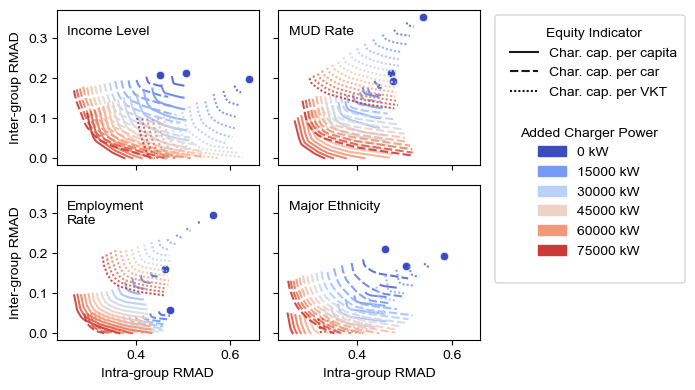

In [11]:
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyBboxPatch

df_temp_plot = df_result_val.copy()
df_temp_plot = df_temp_plot[df_temp_plot["weight_within"] >0][df_temp_plot["weight_between"] >0]
coolwarm = sns.color_palette("coolwarm", as_cmap=True)

fig, ax = plt.subplots(2, 2, figsize=(5, 4), sharex=True, sharey=True)
ax = ax.flatten()
demographic_group_list_name = ["Income Level", "MUD Rate", "Employment\nRate", "Major Ethnicity"]
for one_demo in demographic_group_list:
    i = demographic_group_list.index(one_demo)
    df_temp_plot_one_demo = df_temp_plot[df_temp_plot["demographic_group"] == one_demo]

    max_add_capacity = 0

    df_temp_plot00 = df_temp_plot_one_demo[df_temp_plot_one_demo["max_add_capacity"] == max_add_capacity]

    sns.scatterplot(
            data=df_temp_plot00,
            x="obj_sol_within",
            y="obj_sol_between",
            # style="equity_indicator",
            color=coolwarm(max_add_capacity/80000),
            sizes=(50, 200),
            palette="coolwarm",
            alpha=0.9,
            ax=ax[i],
            # edgecolor="lightgrey",
        )

    
    for max_add_capacity in max_add_capacity_list:
        df_temp_plot00 = df_temp_plot_one_demo[df_temp_plot_one_demo["max_add_capacity"] == max_add_capacity]
        # df_temp_plot00.obj_sol_within = df_temp_plot00.obj_sol_within.round(3)
        # df_temp_plot00.obj_sol_between = df_temp_plot00.obj_sol_between.round(3)
    #scatterplot
        sns.lineplot(
            data=df_temp_plot00,
            x="obj_sol_within",
            y="obj_sol_between",
            style="equity_indicator",
            color=coolwarm(max_add_capacity/80000),
            sizes=(50, 200),
            palette="coolwarm",
            alpha=0.9,
            ax=ax[i],
            # edgecolor="lightgrey",
        )

    ax[i].legend([], [], frameon=False)
    ax[i].set_xlabel("Intra-group RMAD")
    ax[i].set_ylabel("Inter-group RMAD")

ax[0].text(0.05, 0.9, demographic_group_list_name[0], transform=ax[0].transAxes, fontsize=10, verticalalignment='top', color = 'black')
ax[1].text(0.05, 0.9, demographic_group_list_name[1], transform=ax[1].transAxes, fontsize=10, verticalalignment='top')
ax[2].text(0.05, 0.9, demographic_group_list_name[2], transform=ax[2].transAxes, fontsize=10, verticalalignment='top')
ax[3].text(0.05, 0.9, demographic_group_list_name[3], transform=ax[3].transAxes, fontsize=10, verticalalignment='top')

fig.subplots_adjust(hspace=0.5)
handles, labels = ax[0].get_legend_handles_labels()
labels = ["Char. cap. per capita", "Char. cap. per car", "Char. cap. per VKT"]
# set legend handles color to be black
for handle in handles:
    handle.set_color('black')
# create max_add_capacity legend
patchList = []
for i in range(0, len(max_add_capacity_list), 3):
    max_add_capacity = max_add_capacity_list[i]
    data_key = mpatches.Patch(color=coolwarm(max_add_capacity/80000), label=str(max_add_capacity) + " kW")
    patchList.append(data_key)
# remove box around legend

fig.legend(handles[:3],labels[:3], title = "Equity Indicator",
        ncols=1, loc="upper right", bbox_to_anchor=(1.39, 0.95), frameon=False)
fig.legend(handles=patchList, title = "Added Charger Power",
        loc="upper right", bbox_to_anchor=(1.35, 0.7), ncol=1, frameon=False)
# Manually draw a box around the legend
box = FancyBboxPatch((1., 0.28), 0.38, 0.67,boxstyle="round,pad=0,rounding_size=0.006", fill=False, edgecolor='gray', linewidth=0.8, alpha = 0.4, transform=fig.transFigure, figure=fig)
fig.patches.append(box)

plt.tight_layout()
plt.savefig(f"{output_dir}/scatter_2_2.pdf", bbox_inches="tight", dpi = 300)